----------------
# First Approach (Direct Forecasting)
----------------

## Import Libraries

In [19]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

## Get Dataset

In [40]:
dataset_path = "T1.csv"
data = pd.read_csv(dataset_path)

# Change the sampling rate from (10min) to (1hour) to reduce number of samples...
data = data[::6]
data.head()

# Setting the time index
data.index = pd.to_datetime(data['Date/Time'], format="%d %m %Y %H:%M")
data[:5]

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,,
2018-01-01 00:00:00,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 01:00:00,01 01 2018 01:00,447.605713,5.793008,557.372363,266.163605
2018-01-01 02:00:00,01 01 2018 02:00,710.587280,6.547414,824.662514,274.232910
2018-01-01 03:00:00,01 01 2018 03:00,736.647827,6.415083,773.172863,261.158691
2018-01-01 04:00:00,01 01 2018 04:00,1493.807983,7.943102,1497.583724,256.407410


## Visuzallizing Dataset

<Axes: xlabel='Date/Time'>

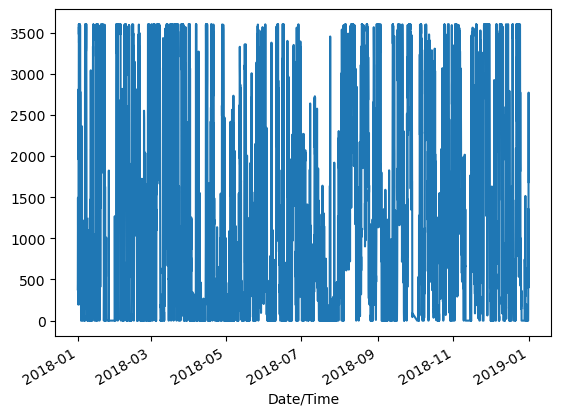

In [41]:
temp = data['LV ActivePower (kW)']
temp.plot()

## Convert Data to X and y

In [42]:
def data_to_X_y(data, window_size=5):
    data_as_np = data.to_numpy()
    X = []
    y = []
    for i in range(len(data_as_np)-window_size):
        row = [[a] for a in data_as_np[i:i+window_size]]
        X.append(row)
        label = data_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [43]:
WINDOW_SIZE = 5
X, y = data_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((8417, 5, 1), (8417,))

## Splitting the Dataset into train/valid/test

In [44]:
all_smaples = X.shape[0]

train_ratio = 0.7
val_ratio = 0.1
# test_ratio = 0.2

split_index_1 = int(train_ratio * all_smaples)
split_index_2 = int(val_ratio * all_smaples)
split_index_2 = split_index_1 + split_index_2

X_train, y_train = X[:split_index_1], y[:split_index_1]
X_val, y_val = X[split_index_1:split_index_2], y[split_index_1:split_index_2]
X_test, y_test = X[split_index_2:], y[split_index_2:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5891, 5, 1), (5891,), (841, 5, 1), (841,), (1685, 5, 1), (1685,))

## Initiallizing Model

In [45]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(128, return_sequences=True))
model1.add(Dropout(0.2))  
model1.add(LSTM(64))
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.2))  
model1.add(Dense(1, activation='linear'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout_6 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 117025 (457.13 KB)
Trainable params: 117

## Training Model

In [46]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [47]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])

Epoch 1/100
178/185 [===========================>..] - ETA: 0s - loss: 3114375.5000 - root_mean_squared_error: 1764.7593INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 11s 43ms/step - loss: 3119661.7500 - root_mean_squared_error: 1766.2565 - val_loss: 3838212.5000 - val_root_mean_squared_error: 1959.1356
Epoch 2/100
178/185 [===========================>..] - ETA: 0s - loss: 2861568.5000 - root_mean_squared_error: 1691.6171INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 33ms/step - loss: 2866045.0000 - root_mean_squared_error: 1692.9397 - val_loss: 3418569.7500 - val_root_mean_squared_error: 1848.9375
Epoch 3/100
179/185 [============================>.] - ETA: 0s - loss: 2484680.7500 - root_mean_squared_error: 1576.2870INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 2483747.5000 - root_mean_squared_error: 1575.9910 - val_loss: 2862926.5000 - val_root_mean_squared_error: 1692.0184
Epoch 4/100
182/185 [============================>.] - ETA: 0s - loss: 2040319.0000 - root_mean_squared_error: 1428.3973INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 2040555.7500 - root_mean_squared_error: 1428.4802 - val_loss: 2279576.0000 - val_root_mean_squared_error: 1509.8265
Epoch 5/100
180/185 [============================>.] - ETA: 0s - loss: 1625883.2500 - root_mean_squared_error: 1275.1013INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 1623047.8750 - root_mean_squared_error: 1273.9890 - val_loss: 1748646.2500 - val_root_mean_squared_error: 1322.3639
Epoch 6/100
182/185 [============================>.] - ETA: 0s - loss: 1256502.0000 - root_mean_squared_error: 1120.9380INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 1257381.6250 - root_mean_squared_error: 1121.3303 - val_loss: 1307339.0000 - val_root_mean_squared_error: 1143.3893
Epoch 7/100
182/185 [============================>.] - ETA: 0s - loss: 986651.5000 - root_mean_squared_error: 993.3033INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 983360.1875 - root_mean_squared_error: 991.6452 - val_loss: 965400.5000 - val_root_mean_squared_error: 982.5480
Epoch 8/100
181/185 [============================>.] - ETA: 0s - loss: 779617.2500 - root_mean_squared_error: 882.9594INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 776728.4375 - root_mean_squared_error: 881.3220 - val_loss: 711315.8125 - val_root_mean_squared_error: 843.3954
Epoch 9/100
180/185 [============================>.] - ETA: 0s - loss: 638238.9375 - root_mean_squared_error: 798.8986INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 640925.8750 - root_mean_squared_error: 800.5785 - val_loss: 569924.0625 - val_root_mean_squared_error: 754.9332
Epoch 10/100
181/185 [============================>.] - ETA: 0s - loss: 567495.1875 - root_mean_squared_error: 753.3228INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 566898.5625 - root_mean_squared_error: 752.9266 - val_loss: 433327.2188 - val_root_mean_squared_error: 658.2759
Epoch 11/100
183/185 [============================>.] - ETA: 0s - loss: 509444.1875 - root_mean_squared_error: 713.7536INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 509856.5312 - root_mean_squared_error: 714.0424 - val_loss: 390980.1562 - val_root_mean_squared_error: 625.2841
Epoch 12/100
184/185 [============================>.] - ETA: 0s - loss: 501315.3125 - root_mean_squared_error: 708.0363INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 501171.7812 - root_mean_squared_error: 707.9349 - val_loss: 346525.0625 - val_root_mean_squared_error: 588.6638
Epoch 13/100
179/185 [============================>.] - ETA: 0s - loss: 465873.7812 - root_mean_squared_error: 682.5495INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 462518.5312 - root_mean_squared_error: 680.0872 - val_loss: 325863.8438 - val_root_mean_squared_error: 570.8448
Epoch 14/100
185/185 [==============================] - 2s 8ms/step - loss: 478903.0938 - root_mean_squared_error: 692.0283 - val_loss: 330778.5625 - val_root_mean_squared_error: 575.1335
Epoch 15/100
185/185 [==============================] - 1s 8ms/step - loss: 428906.9062 - root_mean_squared_error: 654.9099 - val_loss: 377030.6562 - val_root_mean_squared_error: 614.0282
Epoch 16/100
185/185 [==============================] - 2s 8ms/step - loss: 418704.4375 - root_mean_squared_error: 647.0737 - val_loss: 474269.6562 - val_root_mean_squared_error: 688.6724
Epoch 17/100
181/185 [============================>.] - ETA: 0s - loss: 432550.0000 - root_mean_squared_error: 657.6854INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 435287.1250 - root_mean_squared_error: 659.7629 - val_loss: 300252.8125 - val_root_mean_squared_error: 547.9533
Epoch 18/100
179/185 [============================>.] - ETA: 0s - loss: 451574.8750 - root_mean_squared_error: 671.9932INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 450180.6562 - root_mean_squared_error: 670.9550 - val_loss: 282305.1875 - val_root_mean_squared_error: 531.3240
Epoch 19/100
185/185 [==============================] - 2s 9ms/step - loss: 432682.4062 - root_mean_squared_error: 657.7860 - val_loss: 300337.0312 - val_root_mean_squared_error: 548.0302
Epoch 20/100
185/185 [==============================] - 2s 9ms/step - loss: 436730.5625 - root_mean_squared_error: 660.8560 - val_loss: 333851.4375 - val_root_mean_squared_error: 577.7988
Epoch 21/100
180/185 [============================>.] - ETA: 0s - loss: 425228.4375 - root_mean_squared_error: 652.0954INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 38ms/step - loss: 422527.9062 - root_mean_squared_error: 650.0215 - val_loss: 275805.3438 - val_root_mean_squared_error: 525.1718
Epoch 22/100
185/185 [==============================] - 2s 8ms/step - loss: 420703.2500 - root_mean_squared_error: 648.6164 - val_loss: 291431.8438 - val_root_mean_squared_error: 539.8443
Epoch 23/100
185/185 [==============================] - 2s 8ms/step - loss: 423189.2500 - root_mean_squared_error: 650.5300 - val_loss: 282946.8125 - val_root_mean_squared_error: 531.9274
Epoch 24/100
183/185 [============================>.] - ETA: 0s - loss: 434657.8750 - root_mean_squared_error: 659.2859INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 435665.0625 - root_mean_squared_error: 660.0493 - val_loss: 270302.1562 - val_root_mean_squared_error: 519.9059
Epoch 25/100
185/185 [==============================] - 1s 8ms/step - loss: 439566.8125 - root_mean_squared_error: 662.9984 - val_loss: 289775.0938 - val_root_mean_squared_error: 538.3076
Epoch 26/100
185/185 [==============================] - 1s 8ms/step - loss: 422607.1562 - root_mean_squared_error: 650.0824 - val_loss: 362454.4375 - val_root_mean_squared_error: 602.0419
Epoch 27/100
185/185 [==============================] - 2s 8ms/step - loss: 426282.2812 - root_mean_squared_error: 652.9030 - val_loss: 290966.0000 - val_root_mean_squared_error: 539.4127
Epoch 28/100
185/185 [==============================] - 1s 8ms/step - loss: 451946.7812 - root_mean_squared_error: 672.2699 - val_loss: 307927.6875 - val_root_mean_squared_error: 554.9124
Epoch 29/100
185/185 [==============================] - 1s 8ms/step - lo

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 437817.4375 - root_mean_squared_error: 661.6777 - val_loss: 264131.6562 - val_root_mean_squared_error: 513.9374
Epoch 33/100
185/185 [==============================] - 2s 8ms/step - loss: 419195.5312 - root_mean_squared_error: 647.4531 - val_loss: 282070.1875 - val_root_mean_squared_error: 531.1028
Epoch 34/100
185/185 [==============================] - 1s 8ms/step - loss: 430476.1875 - root_mean_squared_error: 656.1068 - val_loss: 330532.0625 - val_root_mean_squared_error: 574.9192
Epoch 35/100
185/185 [==============================] - 2s 8ms/step - loss: 470334.5625 - root_mean_squared_error: 685.8094 - val_loss: 326314.7188 - val_root_mean_squared_error: 571.2396
Epoch 36/100
185/185 [==============================] - 2s 8ms/step - loss: 453542.6875 - root_mean_squared_error: 673.4557 - val_loss: 293256.1875 - val_root_mean_squared_error: 541.5313
Epoch 37/100
185/185 [==============================] - 2s 8ms/step - lo

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 422716.2188 - root_mean_squared_error: 650.1663 - val_loss: 257627.1094 - val_root_mean_squared_error: 507.5698
Epoch 45/100
185/185 [==============================] - 1s 8ms/step - loss: 445780.5625 - root_mean_squared_error: 667.6680 - val_loss: 295427.3438 - val_root_mean_squared_error: 543.5323
Epoch 46/100
185/185 [==============================] - 1s 8ms/step - loss: 419572.2188 - root_mean_squared_error: 647.7440 - val_loss: 276610.9062 - val_root_mean_squared_error: 525.9381
Epoch 47/100
185/185 [==============================] - 1s 8ms/step - loss: 413039.4688 - root_mean_squared_error: 642.6815 - val_loss: 266394.4688 - val_root_mean_squared_error: 516.1342
Epoch 48/100
185/185 [==============================] - 1s 8ms/step - loss: 427517.4062 - root_mean_squared_error: 653.8481 - val_loss: 308513.1562 - val_root_mean_squared_error: 555.4396
Epoch 49/100
185/185 [==============================] - 1s 8ms/step - lo

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 392966.0938 - root_mean_squared_error: 626.8701 - val_loss: 250952.5781 - val_root_mean_squared_error: 500.9517
Epoch 57/100
185/185 [==============================] - 2s 8ms/step - loss: 397078.2500 - root_mean_squared_error: 630.1415 - val_loss: 270456.5938 - val_root_mean_squared_error: 520.0544
Epoch 58/100
185/185 [==============================] - 1s 8ms/step - loss: 395510.2188 - root_mean_squared_error: 628.8961 - val_loss: 280872.5000 - val_root_mean_squared_error: 529.9741
Epoch 59/100
185/185 [==============================] - 1s 8ms/step - loss: 396533.6250 - root_mean_squared_error: 629.7092 - val_loss: 340414.4688 - val_root_mean_squared_error: 583.4505
Epoch 60/100
185/185 [==============================] - 1s 8ms/step - loss: 402170.5312 - root_mean_squared_error: 634.1692 - val_loss: 318094.0000 - val_root_mean_squared_error: 563.9982
Epoch 61/100
185/185 [==============================] - 1s 8ms/step - lo

In [52]:
model1 = load_model('model1/')

In [53]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})

val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'val Predictions': val_predictions, 'Actuals':y_val})

test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions': test_predictions, 'Actuals':y_test})

test_predictions_approach_1 = test_predictions # Will be used later for comparison
test_results_approach_1 = test_results # Will be used later for comparison

53/53 [==============================] - 0s 3ms/step


## Computing Performance Metrics

In [54]:
def compute_metrics(predictions, actuals):
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    
    # Index of Agreement (IA)
    ia = 1 - (np.sum((actuals - predictions)**2)) / (np.sum((np.abs(predictions - np.mean(actuals)) + np.abs(actuals - np.mean(actuals)))**2))
    
    # Standard Deviation Error (SDE)
    sde = np.std(predictions - actuals)
    
    return mae, mape, rmse, r2, ia, sde

train_metrics = compute_metrics(train_predictions, y_train)

val_metrics = compute_metrics(val_predictions, y_val)

test_metrics = compute_metrics(test_predictions, y_test)

results_df = pd.DataFrame({
    'Set': ['Training', 'Validation', 'Test'],
    'MAE': [train_metrics[0], val_metrics[0], test_metrics[0]],
    'MAPE': [train_metrics[1], val_metrics[1], test_metrics[1]],
    'RMSE': [train_metrics[2], val_metrics[2], test_metrics[2]],
    'R2': [train_metrics[3], val_metrics[3], test_metrics[3]],
    'IA': [train_metrics[4], val_metrics[4], test_metrics[4]],
    'SDE': [train_metrics[5], val_metrics[5], test_metrics[5]],
})

results_df.to_csv('RNN_results_Approach_1.csv', index=False)

print('All results have been saved to RNN_results_Approach_1.csv')

All results have been saved to RNN_results_Approach_1.csv


## Plotting GroundTruth VS Predictions

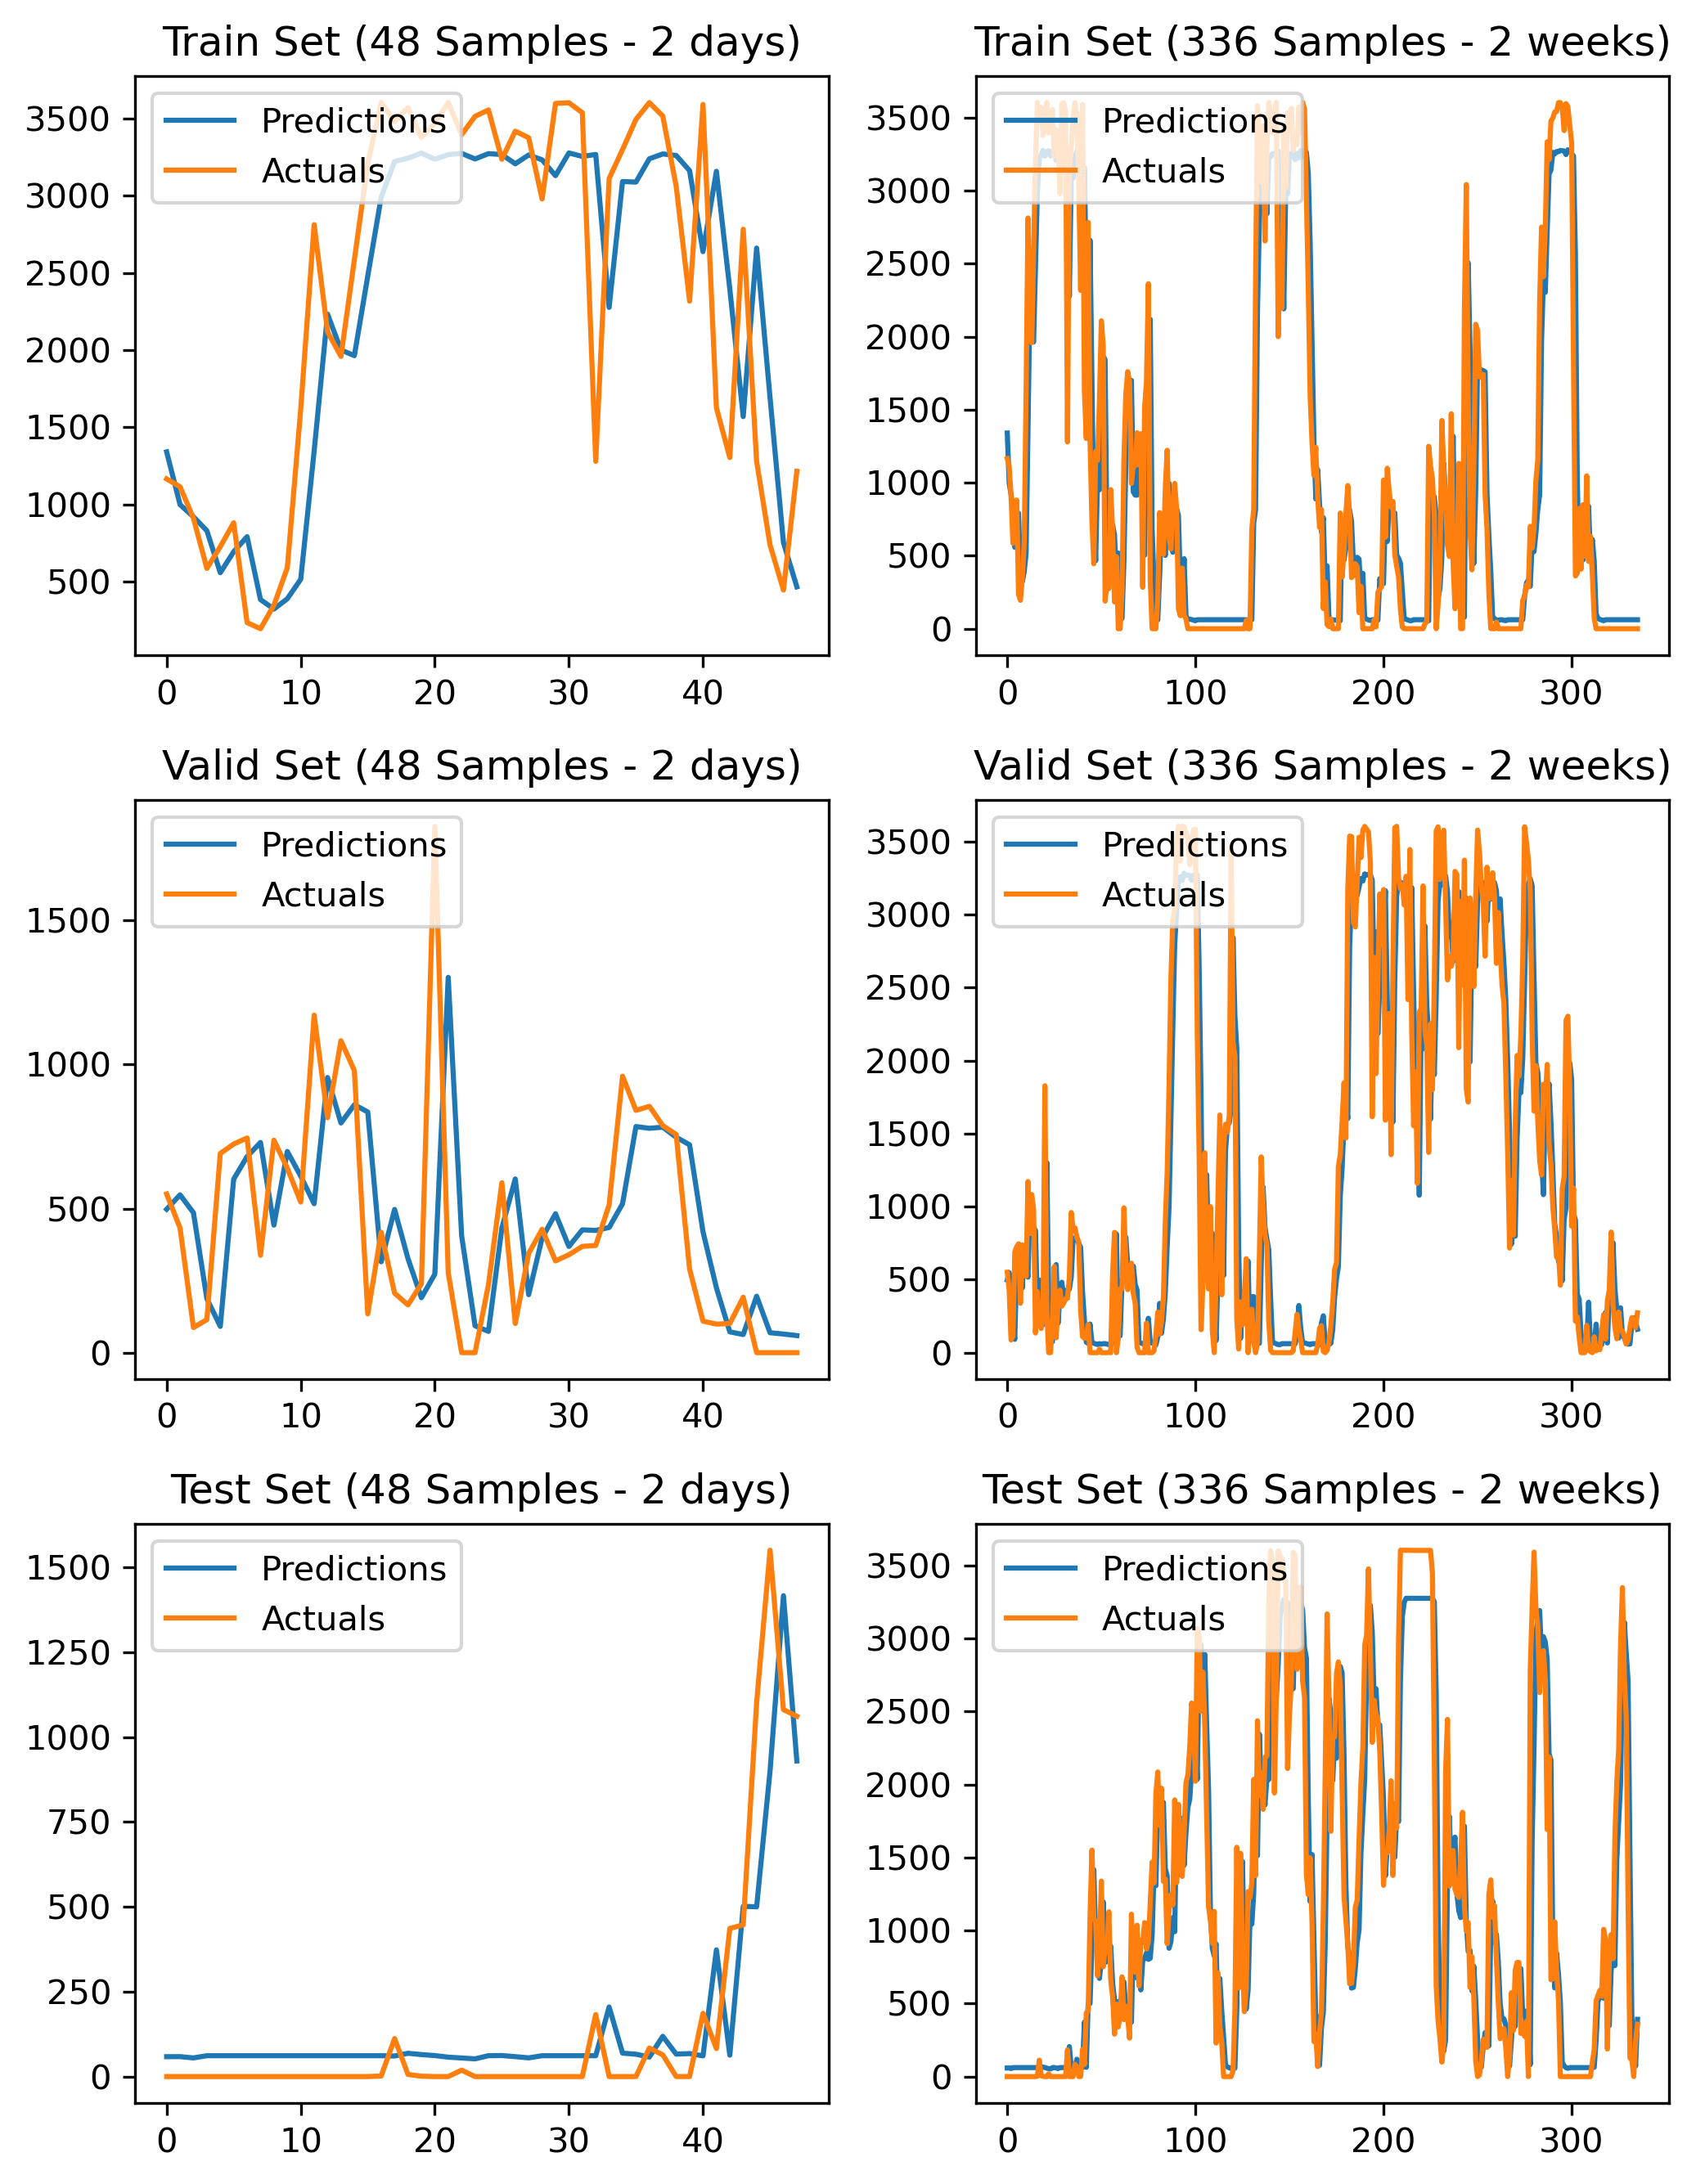

In [55]:
import matplotlib.pyplot as plt

def plot_results(ax, predictions, actuals, title):
    ax.plot(predictions)
    ax.plot(actuals)
    ax.legend(['Predictions', 'Actuals'], loc='upper left')  # Set legend position
    ax.set_title(title)

fig, axs = plt.subplots(3, 2, figsize=(7, 9), dpi=300)  

# Plot train results for 48 samples
plot_results(axs[0, 0], train_results['Train Predictions'][:48], train_results['Actuals'][:48], 'Train Set (48 Samples - 2 days)')

# Plot train results for 336 samples
plot_results(axs[0, 1], train_results['Train Predictions'][:336], train_results['Actuals'][:336], 'Train Set (336 Samples - 2 weeks)')

# Plot valid results for 48 samples
plot_results(axs[1, 0], val_results['val Predictions'][:48], val_results['Actuals'][:48], 'Valid Set (48 Samples - 2 days)')

# Plot valid results for 336 samples
plot_results(axs[1, 1], val_results['val Predictions'][:336], val_results['Actuals'][:336], 'Valid Set (336 Samples - 2 weeks)')

# Plot test results for 48 samples
plot_results(axs[2, 0], test_results['test Predictions'][:48], test_results['Actuals'][:48], 'Test Set (48 Samples - 2 days)')

# Plot test results for 336 samples
plot_results(axs[2, 1], test_results['test Predictions'][:336], test_results['Actuals'][:336], 'Test Set (336 Samples - 2 weeks)')

plt.tight_layout() 

# Save the figure 
plt.savefig('results_plot_Approach_1.png', dpi=300) 
plt.show()

----------------
# Second Approach (Indirect Forecasting)
----------------

## Regression Model

In [56]:
data = pd.read_csv(dataset_path)

# Change the sampling rate from (10min) to (1hour) to reduce number of samples...
data = data[::6]

# Setting the time index
data.index = pd.to_datetime(data['Date/Time'], format="%d %m %Y %H:%M")

target_feature = 'LV ActivePower (kW)'
time_feature = 'Date/Time'
other_features = [col for col in data.columns if col != target_feature and col != time_feature]

# Split Dataset into X and y
X_regression = data[other_features]
y_regression = data[target_feature]

# Splitting Dataset into train/valid/test
all_smaples = data.shape[0]
train_ratio = 0.7
val_ratio = 0.1

split_index_1 = int(train_ratio * all_smaples)
split_index_2 = int(val_ratio * all_smaples)
split_index_2 = split_index_1 + split_index_2

X_regression_train, y_regression_train = X_regression[:split_index_1], y_regression[:split_index_1]
X_regression_val, y_regression_val = X_regression[split_index_1:split_index_2], y_regression[split_index_1:split_index_2]
X_regression_test, y_regression_test = X_regression[split_index_2:], y_regression[split_index_2:]

scaler = MinMaxScaler()
X_regression_train_scaled = scaler.fit_transform(X_regression_train)
X_regression_val_scaled = scaler.transform(X_regression_val)

print("Training Set Shapes:")
print(f"X_regression_train_scaled: {X_regression_train_scaled.shape}, y_regression_train: {y_regression_train.shape}")
print("\nValidation Set Shapes:")
print(f"X_regression_val_scaled: {X_regression_val_scaled.shape}, y_regression_val: {y_regression_val.shape}")
print("\nTest Set Shapes:")
print(f"X_regression_test: {X_regression_test.shape}, y_regression_test: {y_regression_test.shape}")


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_regression_train_scaled, y_regression_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Use the best model
regression_model = grid_search.best_estimator_

# Train the model on the training set
regression_model.fit(X_regression_train_scaled, y_regression_train)

# Predictions on the training set
y_pred_train = regression_model.predict(X_regression_train_scaled)

# Predictions on the validation set
y_pred_val = regression_model.predict(X_regression_val_scaled)

# Evaluate the model on the training set
regression_metrics_train = {
    'MAE': mean_absolute_error(y_regression_train, y_pred_train),
    'RMSE': np.sqrt(mean_squared_error(y_regression_train, y_pred_train)),
    'R2': r2_score(y_regression_train, y_pred_train)
}

# Evaluate the model on the validation set
regression_metrics_val = {
    'MAE': mean_absolute_error(y_regression_val, y_pred_val),
    'RMSE': np.sqrt(mean_squared_error(y_regression_val, y_pred_val)),
    'R2': r2_score(y_regression_val, y_pred_val)
}

print("Regression Model Metrics (Training Set):")
print(regression_metrics_train)

print("\nRegression Model Metrics (Validation Set):")
print(regression_metrics_val)

Training Set Shapes:
X_regression_train_scaled: (5895, 3), y_regression_train: (5895,)

Validation Set Shapes:
X_regression_val_scaled: (842, 3), y_regression_val: (842,)

Test Set Shapes:
X_regression_test: (1685, 3), y_regression_test: (1685,)
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Regression Model Metrics (Training Set):
{'MAE': 118.83593668280247, 'RMSE': 289.21433300671697, 'R2': 0.9505918182213388}

Regression Model Metrics (Validation Set):
{'MAE': 161.44810390888347, 'RMSE': 322.3875908867527, 'R2': 0.9375235830979055}


## Forecasting Model

Feature ==> Wind Speed (m/s)...
(5891, 5) (5891,) (841, 5) (841,) (1685, 5) (1685,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout_8 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                    

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 10s 40ms/step - loss: 16.6719 - root_mean_squared_error: 4.0831 - val_loss: 2.3396 - val_root_mean_squared_error: 1.5296
Epoch 2/100
185/185 [==============================] - 2s 9ms/step - loss: 7.1473 - root_mean_squared_error: 2.6734 - val_loss: 2.8853 - val_root_mean_squared_error: 1.6986
Epoch 3/100
185/185 [==============================] - 2s 9ms/step - loss: 6.7725 - root_mean_squared_error: 2.6024 - val_loss: 2.6363 - val_root_mean_squared_error: 1.6237
Epoch 4/100
185/185 [==============================] - 2s 9ms/step - loss: 6.7499 - root_mean_squared_error: 2.5981 - val_loss: 2.4000 - val_root_mean_squared_error: 1.5492
Epoch 5/100
185/185 [==============================] - 2s 8ms/step - loss: 6.7695 - root_mean_squared_error: 2.6018 - val_loss: 2.6467 - val_root_mean_squared_error: 1.6269
Epoch 6/100
184/185 [============================>.] - ETA: 0s - loss: 6.5851 - root_mean_squared_error: 2.5661INFO:tensorflow:Assets written to

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 6.5851 - root_mean_squared_error: 2.5661 - val_loss: 1.8930 - val_root_mean_squared_error: 1.3759
Epoch 7/100
185/185 [==============================] - 2s 8ms/step - loss: 6.5113 - root_mean_squared_error: 2.5517 - val_loss: 2.2073 - val_root_mean_squared_error: 1.4857
Epoch 8/100
179/185 [============================>.] - ETA: 0s - loss: 6.1616 - root_mean_squared_error: 2.4822INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 6.1459 - root_mean_squared_error: 2.4791 - val_loss: 1.8421 - val_root_mean_squared_error: 1.3572
Epoch 9/100
185/185 [==============================] - 2s 8ms/step - loss: 6.3556 - root_mean_squared_error: 2.5210 - val_loss: 2.3515 - val_root_mean_squared_error: 1.5334
Epoch 10/100
185/185 [==============================] - 2s 8ms/step - loss: 6.5706 - root_mean_squared_error: 2.5633 - val_loss: 1.8729 - val_root_mean_squared_error: 1.3685
Epoch 11/100
185/185 [==============================] - 1s 8ms/step - loss: 6.1280 - root_mean_squared_error: 2.4755 - val_loss: 2.0583 - val_root_mean_squared_error: 1.4347
Epoch 12/100
185/185 [==============================] - 1s 8ms/step - loss: 6.0417 - root_mean_squared_error: 2.4580 - val_loss: 2.1927 - val_root_mean_squared_error: 1.4808
Epoch 13/100
185/185 [==============================] - 2s 8ms/step - loss: 6.0239 - root_mean_squared_error: 2.4544 - val_loss: 2.1749 - val_r

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 38ms/step - loss: 3.8784 - root_mean_squared_error: 1.9694 - val_loss: 1.8396 - val_root_mean_squared_error: 1.3563
Epoch 45/100
185/185 [==============================] - 2s 8ms/step - loss: 4.0388 - root_mean_squared_error: 2.0097 - val_loss: 2.0016 - val_root_mean_squared_error: 1.4148
Epoch 46/100
185/185 [==============================] - 2s 8ms/step - loss: 3.8375 - root_mean_squared_error: 1.9590 - val_loss: 1.8663 - val_root_mean_squared_error: 1.3661
Epoch 47/100
185/185 [==============================] - 1s 8ms/step - loss: 3.8749 - root_mean_squared_error: 1.9685 - val_loss: 1.8448 - val_root_mean_squared_error: 1.3583
Epoch 48/100
185/185 [==============================] - 1s 8ms/step - loss: 3.8569 - root_mean_squared_error: 1.9639 - val_loss: 1.8882 - val_root_mean_squared_error: 1.3741
Epoch 49/100
185/185 [==============================] - 1s 8ms/step - loss: 3.7860 - root_mean_squared_error: 1.9458 - val_loss: 2.1191 - val_

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 3.4556 - root_mean_squared_error: 1.8589 - val_loss: 1.8365 - val_root_mean_squared_error: 1.3552
Epoch 67/100
185/185 [==============================] - 1s 8ms/step - loss: 3.5017 - root_mean_squared_error: 1.8713 - val_loss: 1.9455 - val_root_mean_squared_error: 1.3948
Epoch 68/100
183/185 [============================>.] - ETA: 0s - loss: 3.5831 - root_mean_squared_error: 1.8929INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 3.5813 - root_mean_squared_error: 1.8924 - val_loss: 1.8317 - val_root_mean_squared_error: 1.3534
Epoch 69/100
185/185 [==============================] - 1s 8ms/step - loss: 3.4629 - root_mean_squared_error: 1.8609 - val_loss: 1.8497 - val_root_mean_squared_error: 1.3600
Epoch 70/100
185/185 [==============================] - 2s 8ms/step - loss: 3.4466 - root_mean_squared_error: 1.8565 - val_loss: 1.8801 - val_root_mean_squared_error: 1.3712
Epoch 71/100
185/185 [==============================] - 2s 8ms/step - loss: 3.5187 - root_mean_squared_error: 1.8758 - val_loss: 1.9138 - val_root_mean_squared_error: 1.3834
Epoch 72/100
185/185 [==============================] - 2s 9ms/step - loss: 3.4541 - root_mean_squared_error: 1.8585 - val_loss: 1.8756 - val_root_mean_squared_error: 1.3695
Epoch 73/100
185/185 [==============================] - 2s 8ms/step - loss: 3.3142 - root_mean_squared_error: 1.8205 - val_loss: 1.8745 - val_

INFO:tensorflow:Assets written to: model1\assets


53/53 [==============================] - 1s 3ms/step
Feature ==> Theoretical_Power_Curve (KWh)...
(5891, 5) (5891,) (841, 5) (841,) (1685, 5) (1685,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 128)            66560     
                                                                 
 dropout_10 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 10s 40ms/step - loss: 3820749.2500 - root_mean_squared_error: 1954.6737 - val_loss: 4404994.5000 - val_root_mean_squared_error: 2098.8079
Epoch 2/100
185/185 [==============================] - ETA: 0s - loss: 3608393.2500 - root_mean_squared_error: 1899.5771INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 3608393.2500 - root_mean_squared_error: 1899.5771 - val_loss: 4078257.5000 - val_root_mean_squared_error: 2019.4696
Epoch 3/100
185/185 [==============================] - ETA: 0s - loss: 3275612.0000 - root_mean_squared_error: 1809.8652INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 33ms/step - loss: 3275612.0000 - root_mean_squared_error: 1809.8652 - val_loss: 3622526.7500 - val_root_mean_squared_error: 1903.2937
Epoch 4/100
182/185 [============================>.] - ETA: 0s - loss: 2865698.2500 - root_mean_squared_error: 1692.8373INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 2868670.5000 - root_mean_squared_error: 1693.7150 - val_loss: 3109139.2500 - val_root_mean_squared_error: 1763.2751
Epoch 5/100
180/185 [============================>.] - ETA: 0s - loss: 2443750.7500 - root_mean_squared_error: 1563.2500INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 33ms/step - loss: 2435945.0000 - root_mean_squared_error: 1560.7515 - val_loss: 2582640.2500 - val_root_mean_squared_error: 1607.0594
Epoch 6/100
180/185 [============================>.] - ETA: 0s - loss: 2025265.3750 - root_mean_squared_error: 1423.1182INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 40ms/step - loss: 2021741.8750 - root_mean_squared_error: 1421.8796 - val_loss: 2097055.7500 - val_root_mean_squared_error: 1448.1215
Epoch 7/100
181/185 [============================>.] - ETA: 0s - loss: 1644321.6250 - root_mean_squared_error: 1282.3110INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 1642324.7500 - root_mean_squared_error: 1281.5322 - val_loss: 1674160.0000 - val_root_mean_squared_error: 1293.8933
Epoch 8/100
180/185 [============================>.] - ETA: 0s - loss: 1359403.7500 - root_mean_squared_error: 1165.9347INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 1358644.2500 - root_mean_squared_error: 1165.6090 - val_loss: 1332917.1250 - val_root_mean_squared_error: 1154.5203
Epoch 9/100
181/185 [============================>.] - ETA: 0s - loss: 1086091.0000 - root_mean_squared_error: 1042.1569INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 39ms/step - loss: 1084675.0000 - root_mean_squared_error: 1041.4773 - val_loss: 1031907.2500 - val_root_mean_squared_error: 1015.8284
Epoch 10/100
180/185 [============================>.] - ETA: 0s - loss: 920329.4375 - root_mean_squared_error: 959.3380INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 35ms/step - loss: 917579.4375 - root_mean_squared_error: 957.9037 - val_loss: 830894.8125 - val_root_mean_squared_error: 911.5343
Epoch 11/100
184/185 [============================>.] - ETA: 0s - loss: 761394.0625 - root_mean_squared_error: 872.5790INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 761897.6250 - root_mean_squared_error: 872.8675 - val_loss: 682720.3125 - val_root_mean_squared_error: 826.2689
Epoch 12/100
185/185 [==============================] - ETA: 0s - loss: 688788.8125 - root_mean_squared_error: 829.9330INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 40ms/step - loss: 688788.8125 - root_mean_squared_error: 829.9330 - val_loss: 553286.5625 - val_root_mean_squared_error: 743.8323
Epoch 13/100
181/185 [============================>.] - ETA: 0s - loss: 656217.3750 - root_mean_squared_error: 810.0724INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 40ms/step - loss: 657653.8125 - root_mean_squared_error: 810.9586 - val_loss: 502322.9062 - val_root_mean_squared_error: 708.7474
Epoch 14/100
181/185 [============================>.] - ETA: 0s - loss: 619300.6875 - root_mean_squared_error: 786.9566INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 39ms/step - loss: 619522.6250 - root_mean_squared_error: 787.0976 - val_loss: 481474.4688 - val_root_mean_squared_error: 693.8836
Epoch 15/100
179/185 [============================>.] - ETA: 0s - loss: 590446.5000 - root_mean_squared_error: 768.4052INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 594003.3750 - root_mean_squared_error: 770.7161 - val_loss: 477779.4688 - val_root_mean_squared_error: 691.2159
Epoch 16/100
181/185 [============================>.] - ETA: 0s - loss: 576509.2500 - root_mean_squared_error: 759.2820INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 573014.5000 - root_mean_squared_error: 756.9772 - val_loss: 409215.6875 - val_root_mean_squared_error: 639.6997
Epoch 17/100
180/185 [============================>.] - ETA: 0s - loss: 584611.2500 - root_mean_squared_error: 764.5988INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 38ms/step - loss: 581406.6250 - root_mean_squared_error: 762.5002 - val_loss: 379668.5000 - val_root_mean_squared_error: 616.1725
Epoch 18/100
180/185 [============================>.] - ETA: 0s - loss: 603435.6250 - root_mean_squared_error: 776.8112INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 599928.5625 - root_mean_squared_error: 774.5505 - val_loss: 359424.3750 - val_root_mean_squared_error: 599.5201
Epoch 19/100
183/185 [============================>.] - ETA: 0s - loss: 549765.6250 - root_mean_squared_error: 741.4618INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 549827.8750 - root_mean_squared_error: 741.5038 - val_loss: 344670.9375 - val_root_mean_squared_error: 587.0869
Epoch 20/100
183/185 [============================>.] - ETA: 0s - loss: 526074.4375 - root_mean_squared_error: 725.3099INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 525252.7500 - root_mean_squared_error: 724.7432 - val_loss: 327076.5312 - val_root_mean_squared_error: 571.9061
Epoch 21/100
185/185 [==============================] - 2s 8ms/step - loss: 516148.6562 - root_mean_squared_error: 718.4349 - val_loss: 333183.9375 - val_root_mean_squared_error: 577.2209
Epoch 22/100
185/185 [==============================] - 2s 8ms/step - loss: 521792.4375 - root_mean_squared_error: 722.3520 - val_loss: 454082.1562 - val_root_mean_squared_error: 673.8562
Epoch 23/100
185/185 [==============================] - 1s 8ms/step - loss: 517274.4375 - root_mean_squared_error: 719.2180 - val_loss: 606277.5625 - val_root_mean_squared_error: 778.6382
Epoch 24/100
185/185 [==============================] - 2s 8ms/step - loss: 500140.2188 - root_mean_squared_error: 707.2059 - val_loss: 373718.1562 - val_root_mean_squared_error: 611.3249
Epoch 25/100
185/185 [==============================] - 2s 8ms/step - lo

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 35ms/step - loss: 514259.8125 - root_mean_squared_error: 717.1191 - val_loss: 326172.7812 - val_root_mean_squared_error: 571.1154
Epoch 28/100
185/185 [==============================] - 2s 8ms/step - loss: 566077.6875 - root_mean_squared_error: 752.3813 - val_loss: 334482.2500 - val_root_mean_squared_error: 578.3444
Epoch 29/100
185/185 [==============================] - 1s 8ms/step - loss: 553422.4375 - root_mean_squared_error: 743.9237 - val_loss: 346609.0312 - val_root_mean_squared_error: 588.7351
Epoch 30/100
185/185 [==============================] - 2s 8ms/step - loss: 539913.3750 - root_mean_squared_error: 734.7880 - val_loss: 351695.2188 - val_root_mean_squared_error: 593.0389
Epoch 31/100
185/185 [==============================] - 1s 8ms/step - loss: 546002.1875 - root_mean_squared_error: 738.9196 - val_loss: 329478.4688 - val_root_mean_squared_error: 574.0021
Epoch 32/100
185/185 [==============================] - 2s 8ms/step - lo

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 40ms/step - loss: 524750.3750 - root_mean_squared_error: 724.3965 - val_loss: 312252.8125 - val_root_mean_squared_error: 558.7958
Epoch 34/100
185/185 [==============================] - 2s 9ms/step - loss: 518135.7500 - root_mean_squared_error: 719.8165 - val_loss: 322215.9375 - val_root_mean_squared_error: 567.6407
Epoch 35/100
185/185 [==============================] - ETA: 0s - loss: 507151.7188 - root_mean_squared_error: 712.1459INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 507151.7188 - root_mean_squared_error: 712.1459 - val_loss: 307488.9062 - val_root_mean_squared_error: 554.5168
Epoch 36/100
185/185 [==============================] - 2s 9ms/step - loss: 500702.3750 - root_mean_squared_error: 707.6033 - val_loss: 330972.1875 - val_root_mean_squared_error: 575.3018
Epoch 37/100
185/185 [==============================] - 2s 8ms/step - loss: 518171.5000 - root_mean_squared_error: 719.8413 - val_loss: 320619.0000 - val_root_mean_squared_error: 566.2323
Epoch 38/100
185/185 [==============================] - 1s 8ms/step - loss: 508772.3438 - root_mean_squared_error: 713.2828 - val_loss: 314144.5938 - val_root_mean_squared_error: 560.4860
Epoch 39/100
180/185 [============================>.] - ETA: 0s - loss: 478088.7500 - root_mean_squared_error: 691.4396INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 483999.2188 - root_mean_squared_error: 695.7005 - val_loss: 307438.9062 - val_root_mean_squared_error: 554.4717
Epoch 40/100
185/185 [==============================] - 2s 9ms/step - loss: 494916.4375 - root_mean_squared_error: 703.5030 - val_loss: 315606.4062 - val_root_mean_squared_error: 561.7886
Epoch 41/100
185/185 [==============================] - 2s 8ms/step - loss: 519438.8125 - root_mean_squared_error: 720.7210 - val_loss: 321722.7812 - val_root_mean_squared_error: 567.2061
Epoch 42/100
185/185 [==============================] - 1s 8ms/step - loss: 513120.6562 - root_mean_squared_error: 716.3244 - val_loss: 318184.6250 - val_root_mean_squared_error: 564.0786
Epoch 43/100
185/185 [==============================] - 2s 9ms/step - loss: 513196.0312 - root_mean_squared_error: 716.3770 - val_loss: 329682.6562 - val_root_mean_squared_error: 574.1800
Epoch 44/100
185/185 [==============================] - 1s 8ms/step - lo

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 38ms/step - loss: 493764.1562 - root_mean_squared_error: 702.6835 - val_loss: 306056.0625 - val_root_mean_squared_error: 553.2233
Epoch 46/100
185/185 [==============================] - 2s 8ms/step - loss: 492901.5625 - root_mean_squared_error: 702.0695 - val_loss: 411064.3438 - val_root_mean_squared_error: 641.1430
Epoch 47/100
185/185 [==============================] - 2s 9ms/step - loss: 534468.2500 - root_mean_squared_error: 731.0734 - val_loss: 442890.9062 - val_root_mean_squared_error: 665.5005
Epoch 48/100
185/185 [==============================] - 2s 9ms/step - loss: 541516.6250 - root_mean_squared_error: 735.8781 - val_loss: 376543.8750 - val_root_mean_squared_error: 613.6317
Epoch 49/100
185/185 [==============================] - ETA: 0s - loss: 494130.4062 - root_mean_squared_error: 702.9441INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 494130.4062 - root_mean_squared_error: 702.9441 - val_loss: 305288.0000 - val_root_mean_squared_error: 552.5287
Epoch 50/100
185/185 [==============================] - 2s 9ms/step - loss: 509203.8125 - root_mean_squared_error: 713.5852 - val_loss: 321912.9688 - val_root_mean_squared_error: 567.3737
Epoch 51/100
185/185 [==============================] - 2s 9ms/step - loss: 505899.5000 - root_mean_squared_error: 711.2661 - val_loss: 335132.1250 - val_root_mean_squared_error: 578.9059
Epoch 52/100
185/185 [==============================] - 2s 9ms/step - loss: 505865.9062 - root_mean_squared_error: 711.2425 - val_loss: 487841.0312 - val_root_mean_squared_error: 698.4562
Epoch 53/100
185/185 [==============================] - 1s 8ms/step - loss: 544965.8125 - root_mean_squared_error: 738.2180 - val_loss: 372348.6875 - val_root_mean_squared_error: 610.2038
Epoch 54/100
185/185 [==============================] - 2s 8ms/step - lo

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 464189.7812 - root_mean_squared_error: 681.3148 - val_loss: 302653.9375 - val_root_mean_squared_error: 550.1400
Epoch 86/100
185/185 [==============================] - 2s 9ms/step - loss: 473222.1875 - root_mean_squared_error: 687.9114 - val_loss: 447744.5625 - val_root_mean_squared_error: 669.1372
Epoch 87/100
185/185 [==============================] - 2s 8ms/step - loss: 523009.1875 - root_mean_squared_error: 723.1937 - val_loss: 335840.3438 - val_root_mean_squared_error: 579.5173
Epoch 88/100
185/185 [==============================] - 2s 9ms/step - loss: 498157.5312 - root_mean_squared_error: 705.8027 - val_loss: 319053.5000 - val_root_mean_squared_error: 564.8482
Epoch 89/100
185/185 [==============================] - 2s 9ms/step - loss: 482183.2812 - root_mean_squared_error: 694.3942 - val_loss: 335547.1562 - val_root_mean_squared_error: 579.2643
Epoch 90/100
185/185 [==============================] - 2s 8ms/step - lo

INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 10s 38ms/step - loss: 22706.2734 - root_mean_squared_error: 150.6860 - val_loss: 8263.5000 - val_root_mean_squared_error: 90.9038
Epoch 2/100
181/185 [============================>.] - ETA: 0s - loss: 14326.3467 - root_mean_squared_error: 119.6927INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 14253.9980 - root_mean_squared_error: 119.3901 - val_loss: 5876.9219 - val_root_mean_squared_error: 76.6611
Epoch 3/100
185/185 [==============================] - 2s 8ms/step - loss: 10128.5088 - root_mean_squared_error: 100.6405 - val_loss: 7234.0498 - val_root_mean_squared_error: 85.0532
Epoch 4/100
181/185 [============================>.] - ETA: 0s - loss: 7405.1885 - root_mean_squared_error: 86.0534INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 7355.1987 - root_mean_squared_error: 85.7625 - val_loss: 2835.3118 - val_root_mean_squared_error: 53.2476
Epoch 5/100
179/185 [============================>.] - ETA: 0s - loss: 4298.6826 - root_mean_squared_error: 65.5643INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 35ms/step - loss: 4287.9600 - root_mean_squared_error: 65.4825 - val_loss: 2098.7915 - val_root_mean_squared_error: 45.8126
Epoch 6/100
181/185 [============================>.] - ETA: 0s - loss: 3715.1877 - root_mean_squared_error: 60.9523INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 40ms/step - loss: 3726.4587 - root_mean_squared_error: 61.0447 - val_loss: 1915.5815 - val_root_mean_squared_error: 43.7674
Epoch 7/100
178/185 [===========================>..] - ETA: 0s - loss: 3825.8459 - root_mean_squared_error: 61.8534INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 3794.6311 - root_mean_squared_error: 61.6006 - val_loss: 1820.5410 - val_root_mean_squared_error: 42.6678
Epoch 8/100
180/185 [============================>.] - ETA: 0s - loss: 3764.2542 - root_mean_squared_error: 61.3535INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 37ms/step - loss: 3780.4365 - root_mean_squared_error: 61.4853 - val_loss: 1776.4957 - val_root_mean_squared_error: 42.1485
Epoch 9/100
184/185 [============================>.] - ETA: 0s - loss: 3715.6091 - root_mean_squared_error: 60.9558INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 3714.5659 - root_mean_squared_error: 60.9472 - val_loss: 1769.4336 - val_root_mean_squared_error: 42.0646
Epoch 10/100
183/185 [============================>.] - ETA: 0s - loss: 3659.3579 - root_mean_squared_error: 60.4926INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 6s 34ms/step - loss: 3683.0889 - root_mean_squared_error: 60.6885 - val_loss: 1727.1492 - val_root_mean_squared_error: 41.5590
Epoch 11/100
178/185 [===========================>..] - ETA: 0s - loss: 3659.0552 - root_mean_squared_error: 60.4901INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 39ms/step - loss: 3680.2366 - root_mean_squared_error: 60.6650 - val_loss: 1704.5913 - val_root_mean_squared_error: 41.2867
Epoch 12/100
185/185 [==============================] - 2s 9ms/step - loss: 3627.0508 - root_mean_squared_error: 60.2250 - val_loss: 1707.9908 - val_root_mean_squared_error: 41.3278
Epoch 13/100
185/185 [==============================] - 2s 9ms/step - loss: 3635.8506 - root_mean_squared_error: 60.2980 - val_loss: 1706.9861 - val_root_mean_squared_error: 41.3157
Epoch 14/100
182/185 [============================>.] - ETA: 0s - loss: 3539.2671 - root_mean_squared_error: 59.4917INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


185/185 [==============================] - 7s 36ms/step - loss: 3553.7888 - root_mean_squared_error: 59.6137 - val_loss: 1638.7465 - val_root_mean_squared_error: 40.4814
Epoch 15/100
185/185 [==============================] - 2s 8ms/step - loss: 3701.1577 - root_mean_squared_error: 60.8371 - val_loss: 1701.8212 - val_root_mean_squared_error: 41.2531
Epoch 16/100
185/185 [==============================] - 2s 8ms/step - loss: 3448.1619 - root_mean_squared_error: 58.7211 - val_loss: 1673.6381 - val_root_mean_squared_error: 40.9101
Epoch 17/100
185/185 [==============================] - 2s 8ms/step - loss: 3620.2190 - root_mean_squared_error: 60.1683 - val_loss: 1695.8684 - val_root_mean_squared_error: 41.1809
Epoch 18/100
185/185 [==============================] - 2s 9ms/step - loss: 3501.8208 - root_mean_squared_error: 59.1762 - val_loss: 1707.0189 - val_root_mean_squared_error: 41.3161
Epoch 19/100
185/185 [==============================] - 2s 9ms/step - loss: 3536.9092 - root_mean_squa

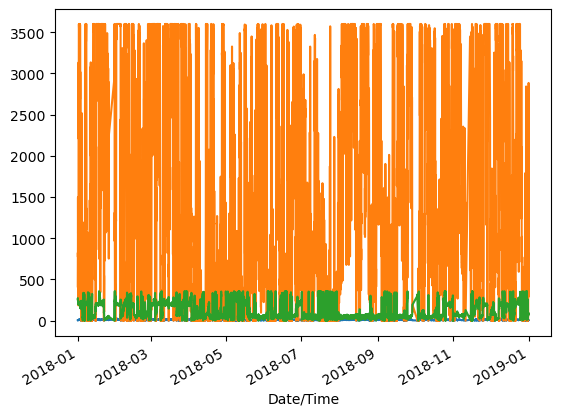

In [57]:
def data_to_X_y(data, window_size=5):
    data_as_np = data.to_numpy()
    X, y = [], []
    
    for i in range(len(data_as_np) - window_size):
        X.append(data_as_np[i:i + window_size])
        y.append(data_as_np[i + window_size])

    return np.array(X), np.array(y)

target_feature = 'LV ActivePower (kW)'
time_feature = 'Date/Time'
other_features = [col for col in data.columns if col != target_feature and col != time_feature]

stage1_data = pd.DataFrame()

stage1_data['LV ActivePower (kW)'] = data['LV ActivePower (kW)'][split_index_2:]

train_ratio, val_ratio = 0.7, 0.1

for feature in other_features:
    print(f"Feature ==> {feature}...")

    temp = data[feature]
    temp.plot()

    X, y = data_to_X_y(temp, WINDOW_SIZE)
    all_samples = X.shape[0]

    split_index_1 = int(train_ratio * all_samples)
    split_index_2 = split_index_1 + int(val_ratio * all_samples)

    X_train, y_train = X[:split_index_1], y[:split_index_1]
    X_val, y_val = X[split_index_1:split_index_2], y[split_index_1:split_index_2]
    X_test, y_test = X[split_index_2:], y[split_index_2:]

    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    model1 = Sequential()
    model1.add(InputLayer((WINDOW_SIZE, 1)))
    model1.add(LSTM(128, return_sequences=True))
    model1.add(Dropout(0.2))  
    model1.add(LSTM(64))
    model1.add(Dense(16, activation='relu'))
    model1.add(Dropout(0.2)) 
    model1.add(Dense(1, activation='linear'))

    model1.summary()

    cp = ModelCheckpoint('model1/', save_best_only=True)
    model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

    model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])

    model1 = load_model('model1/')

    test_predictions = model1.predict(X_test).flatten()
    stage1_data[f'{feature}'] = y_test
    stage1_data[f'{feature}_Prediction'] = test_predictions

## Combine Models

In [58]:
X_regression_test_from_LSTM = stage1_data[other_features]
X_regression_test_from_LSTM_scaled = scaler.transform(X_regression_test_from_LSTM)
y_pred_test = regression_model.predict(X_regression_test_from_LSTM_scaled)
stage1_data['LV ActivePower (kW)_Prediction'] = y_pred_test
stage1_data.head()

,LV ActivePower (kW),Wind Speed (m/s),Wind Speed (m/s)_Prediction,Theoretical_Power_Curve (KWh),Theoretical_Power_Curve (KWh)_Prediction,Wind Direction (°),Wind Direction (°)_Prediction,LV ActivePower (kW)_Prediction
Date/Time,,,,,,,,
2018-10-18 22:20:00,0.0,1.898071,2.950146,0.0,61.907089,192.741898,203.229446,0.00016
2018-10-18 23:20:00,0.0,2.038939,2.533627,0.0,47.383083,241.738693,190.934448,0.00016
2018-10-19 00:20:00,0.0,1.361134,2.492626,0.0,43.254089,275.706390,227.165894,0.00016
2018-10-19 01:20:00,0.0,1.550176,2.231659,0.0,17.354645,249.804993,250.113495,0.00016
2018-10-19 02:20:00,0.0,1.273786,2.226438,0.0,17.354645,273.951294,249.231293,0.00016


## Performance Metrics (First Approach vs Second Approach)

In [60]:
def compute_metrics(predictions, actuals):
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    
    # Index of Agreement (IA)
    ia = 1 - (np.sum((actuals - predictions)**2)) / (np.sum((np.abs(predictions - np.mean(actuals)) + np.abs(actuals - np.mean(actuals)))**2))
    
    # Standard Deviation Error (SDE)
    sde = np.std(predictions - actuals)
    
    return mae, mape, rmse, r2, ia, sde


# Compute metrics for first approach
test_metrics_approach_1 = compute_metrics(test_predictions_approach_1, stage1_data['LV ActivePower (kW)'])

# Compute metrics for second approach
test_metrics_approach_2 = compute_metrics(stage1_data['LV ActivePower (kW)_Prediction'], stage1_data['LV ActivePower (kW)'])

# Storing results
results_df = pd.DataFrame({
    'Approach': ['Apprahch 1 (Direct)', 'Approach 2 (In-Direct)'],
    'MAE': [test_metrics_approach_1[0], test_metrics_approach_2[0]],
    'MAPE': [test_metrics_approach_1[1], test_metrics_approach_2[1]],
    'RMSE': [test_metrics_approach_1[2], test_metrics_approach_2[2]],
    'R2': [test_metrics_approach_1[3], test_metrics_approach_2[3]],
    'IA': [test_metrics_approach_1[4], test_metrics_approach_2[4]],
    'SDE': [test_metrics_approach_1[5], test_metrics_approach_2[5]],
})

# Saving results 
results_df.to_csv('Combined_Model_Results.csv', index=False)

print('Results have been saved to Combined_Model_Results.csv')

Results have been saved to Combined_Model_Results.csv


## Plots (First Approach vs Second Approach)

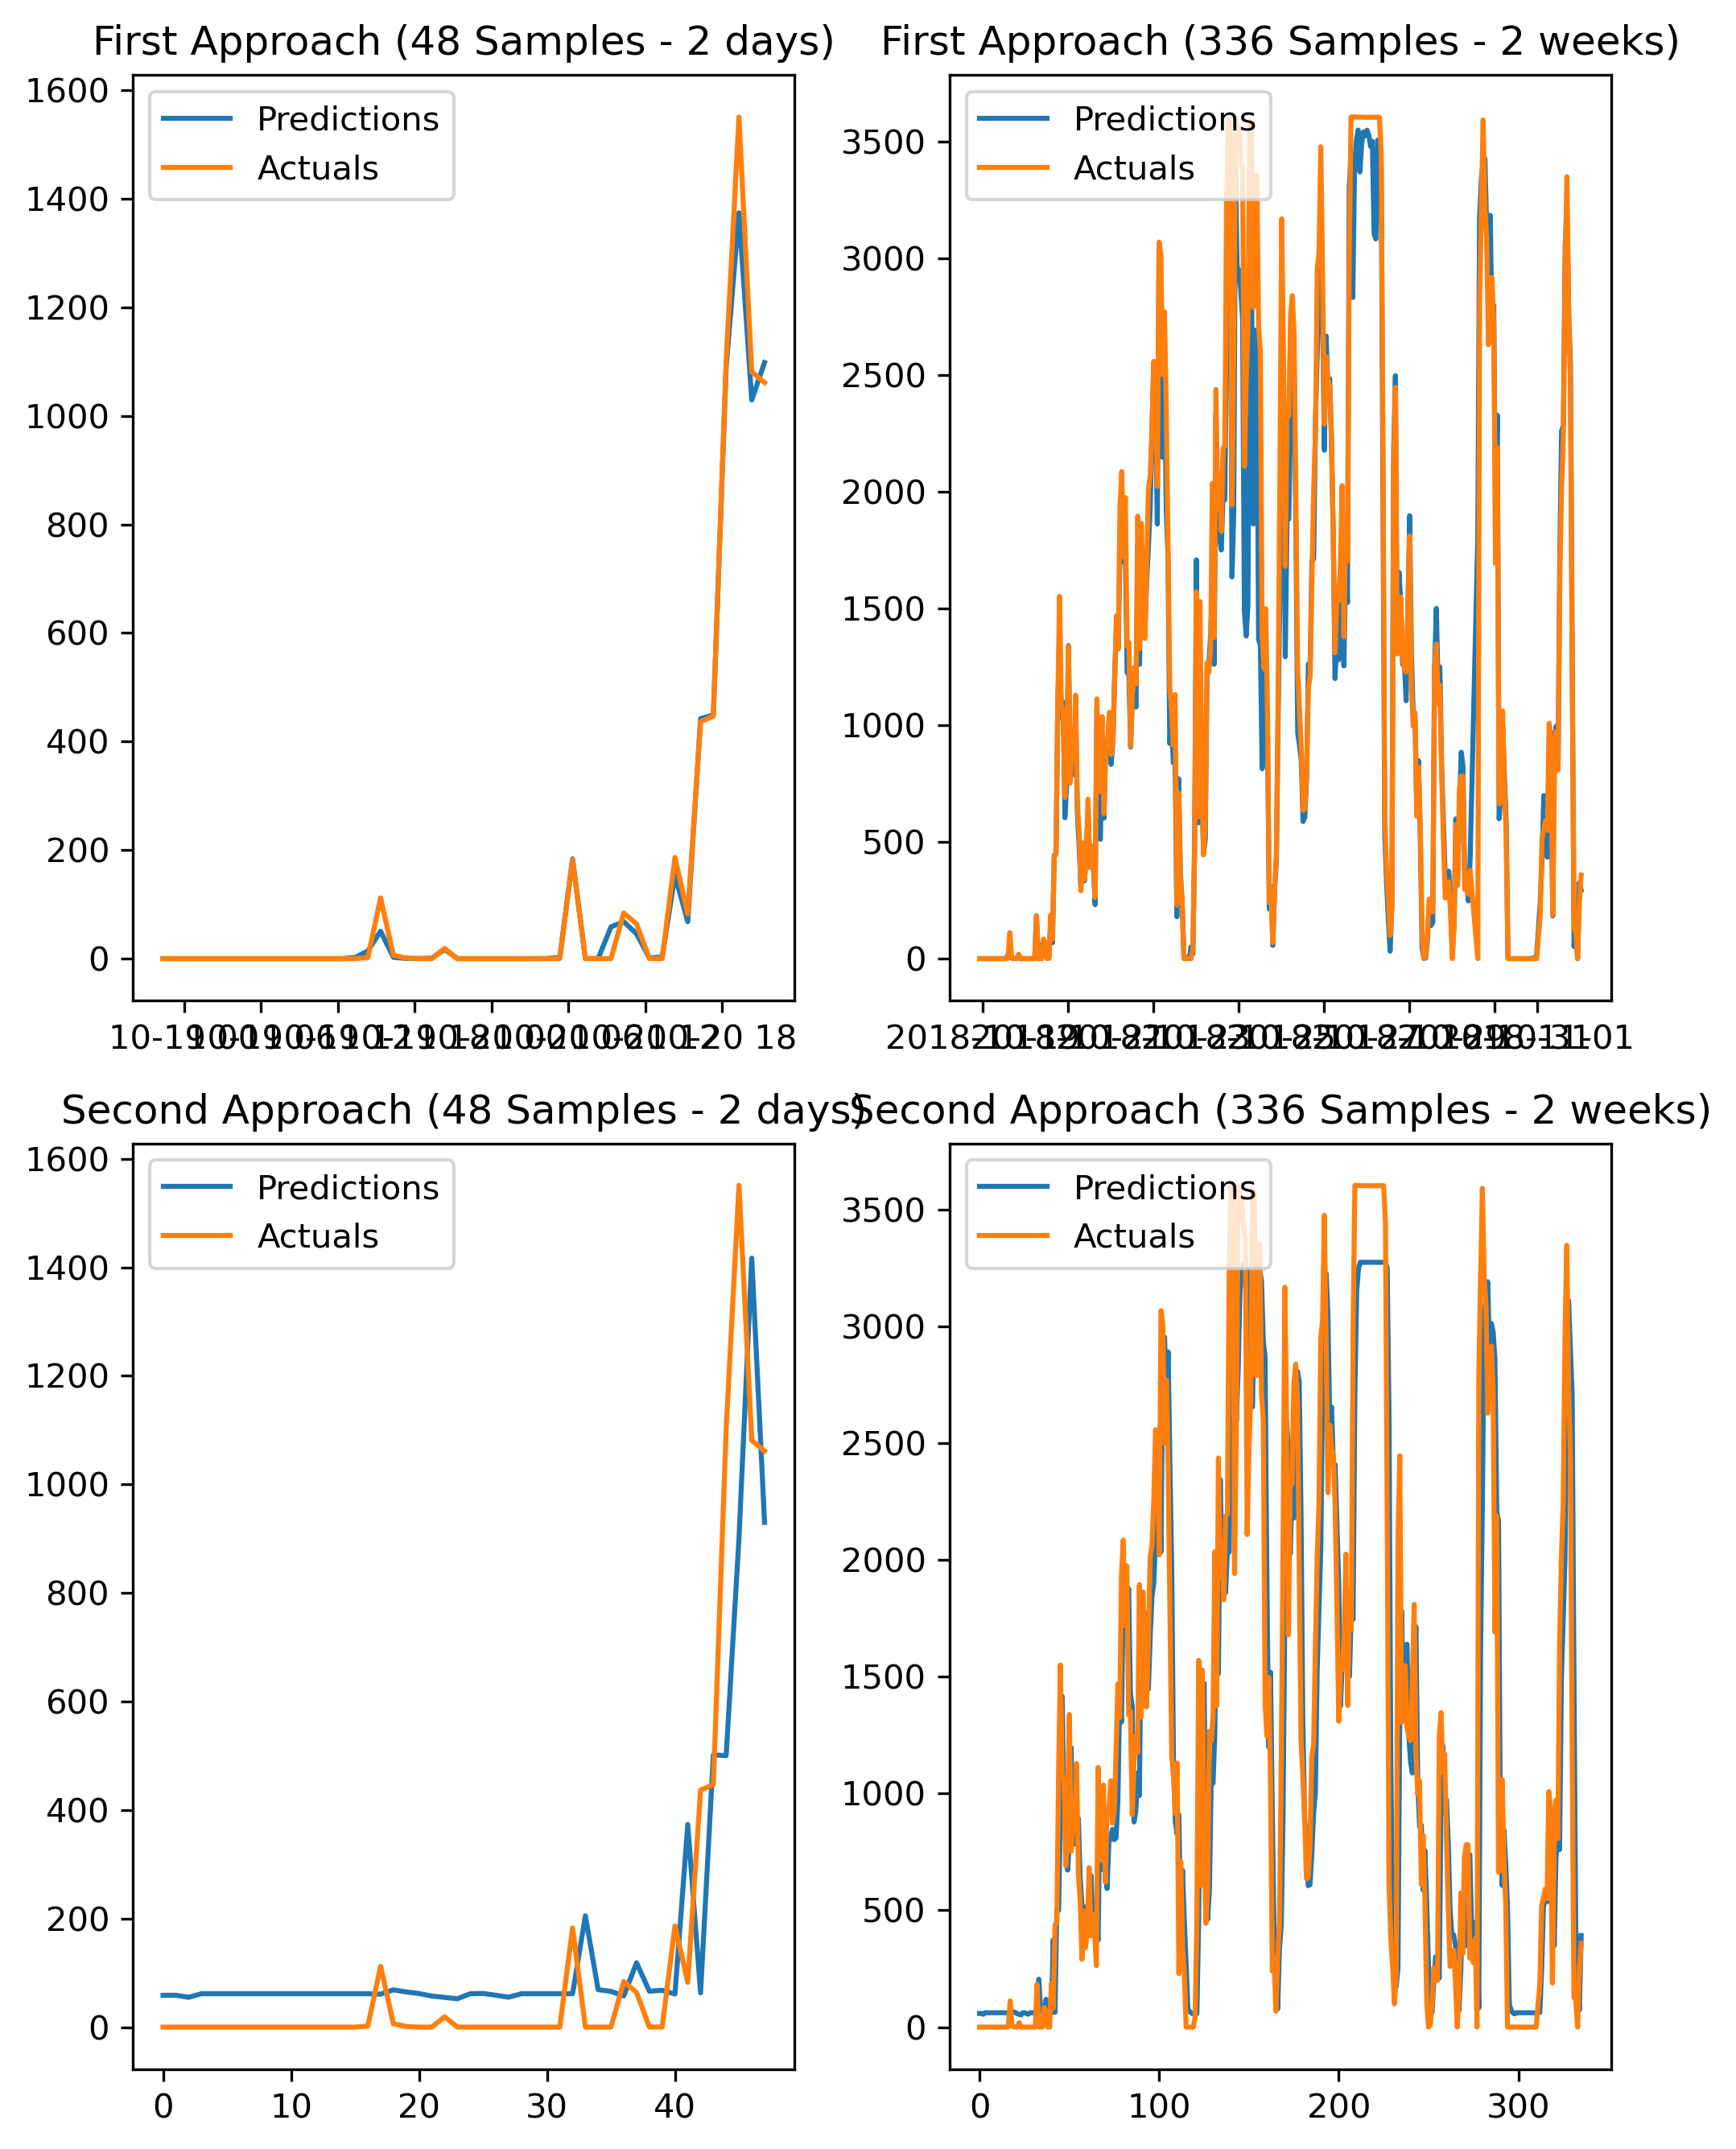

In [64]:
def plot_results(ax, predictions, actuals, title):
    ax.plot(predictions)
    ax.plot(actuals)
    ax.legend(['Predictions', 'Actuals'], loc='upper left')  # Set legend position
    ax.set_title(title)

fig, axs = plt.subplots(2, 2, figsize=(7, 9), dpi=300)

# Plot test results for 48 samples (2 days)
plot_results(axs[0, 0], stage1_data['LV ActivePower (kW)_Prediction'][:48], stage1_data['LV ActivePower (kW)'][:48], 'First Approach (48 Samples - 2 days)')

# Plot test results for 336 samples (2 weeks)
plot_results(axs[0, 1], stage1_data['LV ActivePower (kW)_Prediction'][:336], stage1_data['LV ActivePower (kW)'][:336], 'First Approach (336 Samples - 2 weeks)')


# Plot test results for 48 samples
plot_results(axs[1, 0], test_results_approach_1['test Predictions'][:48], test_results_approach_1['Actuals'][:48], 'Second Approach (48 Samples - 2 days)')

# Plot test results for 336 samples
plot_results(axs[1, 1], test_results_approach_1['test Predictions'][:336], test_results_approach_1['Actuals'][:336], 'Second Approach (336 Samples - 2 weeks)')

plt.tight_layout()  
plt.savefig('combined_results_subplots.png', dpi=300)  # Save the figure
plt.show()


# Done!